In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', 'ed53eadadbcd4844971b58e98663c996')

In [5]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128)>

In [6]:
def search_images_bing(key, term, max_images: int = 150, **kwargs):    
    params = {'q':term, 'count':max_images}
    headers = {"Ocp-Apim-Subscription-Key":key}
    search_url = "https://api.bing.microsoft.com/v7.0/images/search"
    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json() 
   
    # returns an L object to be identical to the original function.
    return L(search_results['value'])

search_images_bing

<function __main__.search_images_bing(key, term, max_images: int = 150, **kwargs)>

In [7]:
results = search_images_bing(key, 'basketball ball')
ims = results.attrgot('contentUrl')
len(ims)

150

In [8]:
#hide
ims = ['https://upload.wikimedia.org/wikipedia/commons/7/7a/Basketball.png']

In [9]:
dest = 'images/basket_ball.jpg'
download_url(ims[0], dest)

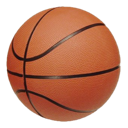

In [10]:
im = Image.open(dest)
im.to_thumb(128,128)

In [11]:
ball_types = 'basket','volleyball','tennis'
path = Path('balls')

In [12]:
if not path.exists():
    path.mkdir()
    for o in ball_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} balls')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [13]:
fns = get_image_files(path)
fns

(#443) [Path('balls/basket/00000007.jpg'),Path('balls/basket/00000006.jpg'),Path('balls/basket/00000001.jpg'),Path('balls/basket/00000000.jpg'),Path('balls/basket/00000005.jpg'),Path('balls/basket/00000009.jpg'),Path('balls/basket/00000003.jpg'),Path('balls/basket/00000002.jpeg'),Path('balls/basket/00000012.jpg'),Path('balls/basket/00000008.jpg')...]

In [14]:
failed = verify_images(fns)
failed

(#7) [Path('balls/basket/00000093.png'),Path('balls/basket/00000121.jpg'),Path('balls/basket/00000135.jpg'),Path('balls/volleyball/00000046.png'),Path('balls/volleyball/00000072.png'),Path('balls/volleyball/00000144.png'),Path('balls/tennis/00000099.jpg')]

In [15]:
failed.map(Path.unlink);

In [16]:
balls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [17]:
dls = balls.dataloaders(path)

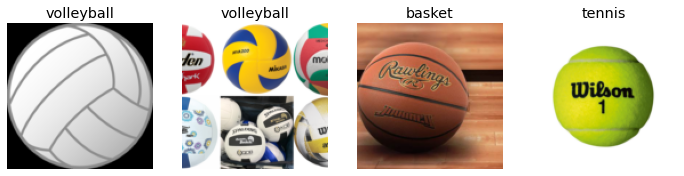

In [18]:
dls.valid.show_batch(max_n=4, nrows=1)

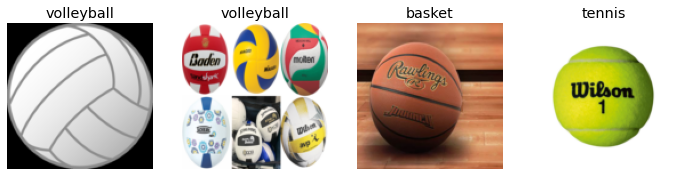

In [19]:
balls = balls.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = balls.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

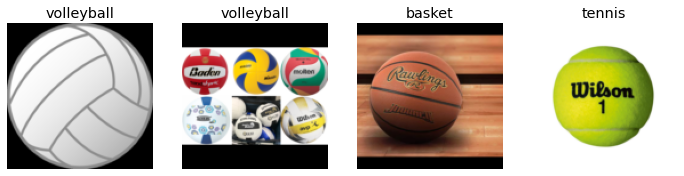

In [20]:
balls = balls.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = balls.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

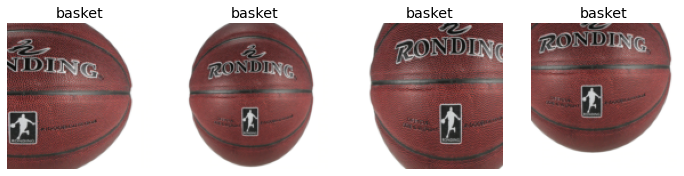

In [21]:
balls = balls.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = balls.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

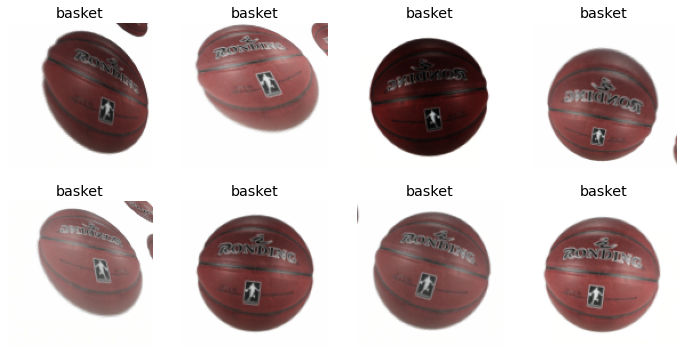

In [23]:
balls = balls.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = balls.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [24]:
balls = balls.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = balls.dataloaders(path)

In [25]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.505342,0.595530,0.160920,00:09


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.413046,0.154811,0.045977,00:10
1,0.313381,0.144720,0.022989,00:09
2,0.230424,0.146056,0.022989,00:10
3,0.176300,0.135139,0.022989,00:09


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: U

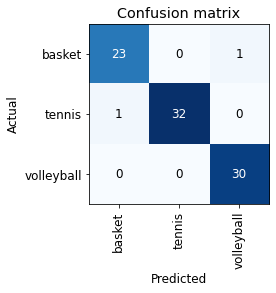

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

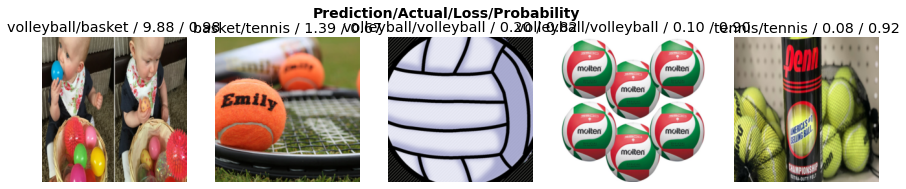

In [27]:
interp.plot_top_losses(5, nrows=1)

In [28]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [29]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [30]:
learn.export()

In [31]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [32]:
learn_inf = load_learner(path/'export.pkl')

In [35]:
learn_inf.predict('images/basket_ball.jpg')

('basket', TensorImage(0), TensorImage([1.0000e+00, 4.1083e-07, 6.7843e-08]))

In [36]:
learn_inf.dls.vocab

['basket', 'tennis', 'volleyball']

In [37]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [38]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/basket_ball.jpg'])

In [39]:
img = PILImage.create(btn_upload.data[-1])

In [40]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [41]:
pred,pred_idx,probs = learn_inf.predict(img)

In [42]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: basket; Probability: 1.0000')

In [43]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [44]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [45]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [47]:
#hide_output
VBox([widgets.Label('Select your ball!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [48]:
#hide
# !pip install voila
# !jupyter serverextension enable voila —sys-prefix